I will perform the data cleaning and feature engineering steps into the same notebook, due to the fact that there involve less steps than usual: dropping columns with missing values, computing missing values, creating new features etc. In larger projects, they should be split:

Initial analysis <br>
Data cleaning<br>
Feature Engineering <br>
Feature Selection <br>
Pipeline<br>
Prediction run<br>


In [216]:
#imports 
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from textacy import preprocessing
import textacy

import spacy
nlp = spacy.load('en_core_web_sm')

# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [109]:
#read data
calendar = pd.read_csv('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/raw_data/calendar.csv')
listings =  pd.read_csv('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/raw_data/listings.csv')
reviews = pd.read_csv('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/raw_data/reviews.csv')

From the previous notebook, in which we initially explored the data, we have defined the folling questions to answer:
1. When are the busiest times in Boston? Which are the busiest neghbourhoods? 
I will perform some descriptive statistics and visualisations. 
In order to answer that, we will use the calendar data create occupancy metrics based on calendar data, to understand the occupancy levels throughout the year. Add to this data the neighbourhood information. 
2. What drives/defines the prices of the AirBNB in Boston? Which are the top variables that affect the price? 
We will build a regression model to predict a continuous variable, and to understand the features that drive the model. 
3. What drives the occupancy rates of the AirBNBs in Boston? Which are more engaged than others? What are the factors/variables that define higher occupancy rates? 
We will discretize the occupancy rates into several categories, and then build a multi-class classification model to predict the occupancy rates. 

# 1. Data cleaning

### Check for duplicates, columns with repeated values, drop unnecessary columns

####  Calendar data

In [110]:
calendar.shape

(1308890, 4)

In [111]:
calendar.drop_duplicates(subset=['listing_id','date'],inplace=True)

In [112]:
calendar.shape

(1308525, 4)

In [113]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = calendar['date'].map(lambda x: x.strftime('%Y-%m'))
#calendar['week'] = calendar['date'].map(lambda x: x.strftime("%V"))

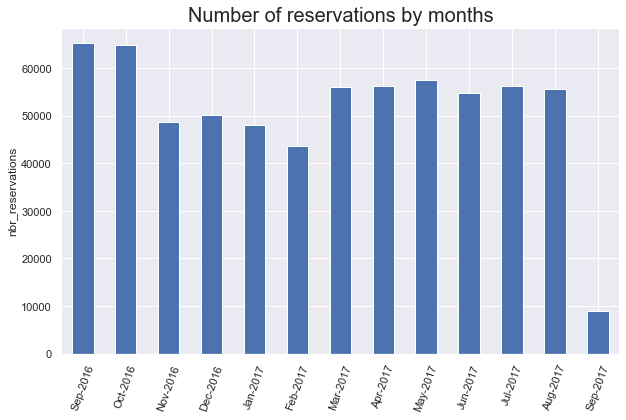

In [114]:
fig, ax = plt.subplots(figsize=(10,6))
cal_month = calendar[calendar['available']=='f']['date'].value_counts().resample('M').sum()
cal_month.plot(kind = 'bar', color='b')
plt.xticks(rotation=70)
ax.set_xticklabels(cal_month.index.strftime('%b-%Y'))
plt.ylabel('nbr_reservations')
plt.title('Number of reservations by months', size = 20);
#plt.legend(bbox_to_anchor=(1, 1),title = 'Vendor')

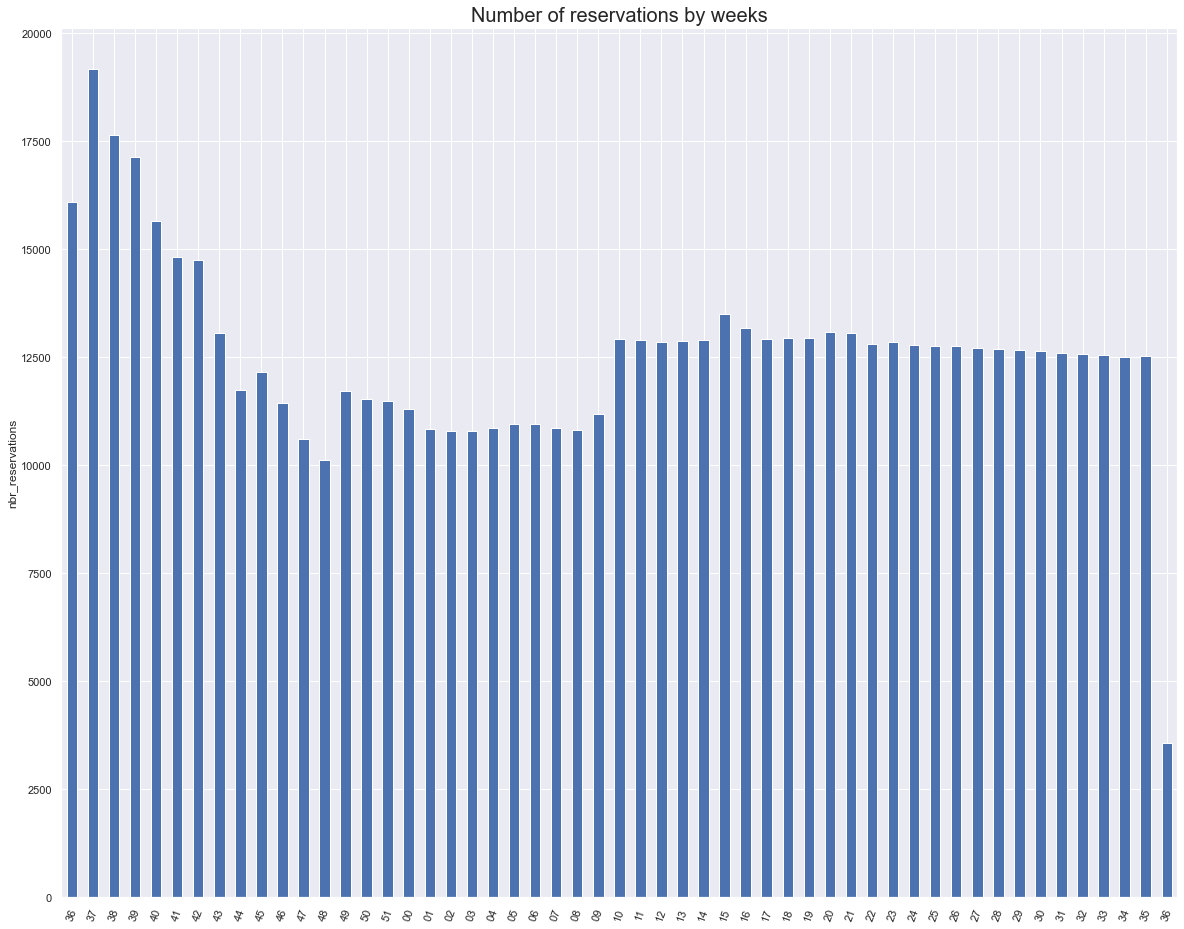

In [115]:
fig, ax = plt.subplots(figsize=(20,16))
cal_month = calendar[calendar['available']=='f']['date'].value_counts().resample('W').sum()
cal_month.plot(kind = 'bar', color='b')
plt.xticks(rotation=70)
ax.set_xticklabels(cal_month.index.strftime('%W'))
plt.ylabel('nbr_reservations')
plt.title('Number of reservations by weeks', size = 20);
#plt.legend(bbox_to_anchor=(1, 1),title = 'Vendor')

In [116]:
cal_month

2016-09-11    16094
2016-09-18    19168
2016-09-25    17644
2016-10-02    17141
2016-10-09    15655
2016-10-16    14824
2016-10-23    14752
2016-10-30    13060
2016-11-06    11749
2016-11-13    12162
2016-11-20    11441
2016-11-27    10601
2016-12-04    10128
2016-12-11    11708
2016-12-18    11527
2016-12-25    11488
2017-01-01    11310
2017-01-08    10845
2017-01-15    10782
2017-01-22    10795
2017-01-29    10870
2017-02-05    10944
2017-02-12    10950
2017-02-19    10869
2017-02-26    10825
2017-03-05    11174
2017-03-12    12921
2017-03-19    12898
2017-03-26    12850
2017-04-02    12865
2017-04-09    12901
2017-04-16    13510
2017-04-23    13171
2017-04-30    12918
2017-05-07    12955
2017-05-14    12938
2017-05-21    13080
2017-05-28    13057
2017-06-04    12812
2017-06-11    12846
2017-06-18    12776
2017-06-25    12768
2017-07-02    12766
2017-07-09    12714
2017-07-16    12683
2017-07-23    12673
2017-07-30    12651
2017-08-06    12604
2017-08-13    12579
2017-08-20    12541


In [117]:
cal_month_avail = calendar.groupby(['listing_id','month','available']).agg({'date':'nunique'}).reset_index()

In [118]:
cal_month_total = cal_month_avail.groupby(['listing_id','month']).agg({'date':'sum'}).reset_index()
cal_month_total.rename({'date':'total_days'},inplace=True,axis=1)

In [119]:
cal_month_busy = cal_month_avail[cal_month_avail['available']=='f'].groupby(['listing_id','month']).agg({'date':'sum'}).reset_index()
cal_month_busy.rename({'date':'busy_days'},inplace=True,axis=1)

In [120]:
cal_month_total = cal_month_total.merge(cal_month_busy, how = 'left', on = ['listing_id','month'])

In [121]:
cal_month_total['busy_days'].fillna(0,inplace=True)
cal_month_total['occupancy_metrics'] = cal_month_total['busy_days']/cal_month_total['total_days']*100

In [122]:
cal_metrics_total = cal_month_total.groupby(['listing_id']).agg({'total_days':'sum','busy_days':'sum'}).reset_index()
#cal_metrics_total.sort_values(by='occupancy_metrics',ascending =False).head()

In [123]:
cal_metrics_total['occupancy_metrics'] = round(cal_metrics_total['busy_days']/cal_metrics_total['total_days']*100,0)

In [124]:
cal_metrics_total.head()

listing_id  total_days  busy_days  occupancy_metrics
0        3353         365      116.0               32.0
1        5506         365       21.0                6.0
2        6695         365       41.0               11.0
3        6976         365       46.0               13.0
4        8792         365      117.0               32.0

In [125]:
cal_metrics_total.shape

(3585, 4)

<AxesSubplot:xlabel='occupancy_metrics', ylabel='Count'>

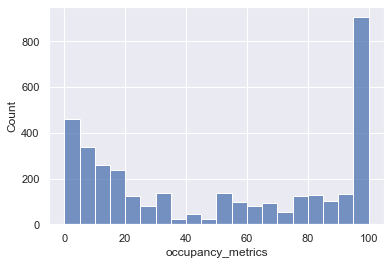

In [126]:
sns.histplot(cal_metrics_total['occupancy_metrics'],bins=20)

In [127]:
#20% of the listings are fully booked throughout the year
cal_metrics_total[cal_metrics_total['occupancy_metrics']==100].shape

(705, 4)

In [128]:
cal_metrics_total[cal_metrics_total['occupancy_metrics']<=40].shape

(1660, 4)

#### Listings data

In [129]:
listings.describe()

id     scrape_id       host_id  host_listings_count  \
count  3.585000e+03  3.585000e+03  3.585000e+03          3585.000000   
mean   8.440875e+06  2.016091e+13  2.492311e+07            58.902371   
std    4.500787e+06  8.516813e-01  2.292781e+07           171.119663   
min    3.353000e+03  2.016091e+13  4.240000e+03             0.000000   
25%    4.679319e+06  2.016091e+13  6.103425e+06             1.000000   
50%    8.577620e+06  2.016091e+13  1.928100e+07             2.000000   
75%    1.278953e+07  2.016091e+13  3.622147e+07             7.000000   
max    1.493346e+07  2.016091e+13  9.385411e+07           749.000000   

       host_total_listings_count  neighbourhood_group_cleansed     latitude  \
count                3585.000000                           0.0  3585.000000   
mean                   58.902371                           NaN    42.340032   
std                   171.119663                           NaN     0.024403   
min                     0.000000                           NaN    42.235942   
25%                     1.000000                           NaN    42.329995   
50%                     2.000000                           NaN    42.345201   
75%                     7.000000                           NaN    42.354685   
max                   749.000000                           NaN    42.389982   

         longitude  accommodates    bathrooms     bedrooms         beds  \
count  3585.000000   3585.000000  3571.000000  3575.000000  3576.000000   
mean    -71.084818      3.041283     1.221647     1.255944     1.609060   
std       0.031565      1.778929     0.501487     0.753060     1.011745   
min     -71.171789      1.000000     0.000000     0.000000     0.000000   
25%     -71.105083      2.000000     1.000000     1.000000     1.000000   
50%     -71.078429      2.000000     1.000000     1.000000     1.000000   
75%     -71.062155      4.000000     1.000000     2.000000     2.000000   
max     -71.000100     16.000000     6.000000     5.000000    16.000000   

       square_feet  guests_included  minimum_nights  maximum_nights  \
count    56.000000      3585.000000     3585.000000    3.585000e+03   
mean    858.464286         1.429847        3.171269    2.872584e+04   
std     608.874310         1.056787        8.874133    1.670136e+06   
min       0.000000         0.000000        1.000000    1.000000e+00   
25%     415.000000         1.000000        1.000000    3.650000e+02   
50%     825.000000         1.000000        2.000000    1.125000e+03   
75%    1200.000000         1.000000        3.000000    1.125000e+03   
max    2400.000000        14.000000      300.000000    1.000000e+08   

       has_availability  availability_30  availability_60  availability_90  \
count               0.0       3585.00000      3585.000000      3585.000000   
mean                NaN          8.64993        21.833194        38.558159   
std                 NaN         10.43533        21.860966        33.158272   
min                 NaN          0.00000         0.000000         0.000000   
25%                 NaN          0.00000         0.000000         0.000000   
50%                 NaN          4.00000        16.000000        37.000000   
75%                 NaN         15.00000        40.000000        68.000000   
max                 NaN         30.00000        60.000000        90.000000   

       availability_365  number_of_reviews  review_scores_rating  \
count       3585.000000        3585.000000           2772.000000   
mean         179.346444          19.044630             91.916667   
std          142.136180          35.571658              9.531686   
min            0.000000           0.000000             20.000000   
25%           19.000000           1.000000             89.000000   
50%          179.000000           5.000000             94.000000   
75%          325.000000          21.000000             98.250000   
max          365.000000         404.000000            100.000000   

       review_scores_acc

In [130]:
listings.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         summary  \
0                                                                                                                                                                                                                                                      Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.   
1                                                                                                                                                                                                                                                        Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly.   
2                                                                                                                                                                                                                                                           Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art.    
3  Come experience the comforts of home away from home in our fabulous bedroom suite available in Roslindale, a neighborhood in Boston.  Enjoy sleeping on a large king sized bed with plush down bedding, access to a dishwasher, washer dryer and home gym. The house is incredibly accessible to public transportation and the center of Boston. Free street parking is available right in front of the house. Weekend farmers markets, restaurants and grocery stores are a 10 min walk away from the house.   
4                                                                                                                                                                                                                                                          My comfy, clean and relaxing home is one block away from the bus line, on a quiet residential street.  Private room includes two comfortable single beds.  Full bath and half bath may be shared with 1-2 other guests.  Light breakfast included. AC   

                                                                                                                                                                                                    

In [131]:
missing_values = listings.isna().sum()/listings.shape[0]*100
missing_values.sort_values(ascending = False)

has_availability                    100.000000
license                             100.000000
neighbourhood_group_cleansed        100.000000
jurisdiction_names                  100.000000
square_feet                          98.437936
monthly_price                        75.230126
weekly_price                         75.118550
security_deposit                     62.566248
notes                                55.090656
interaction                          43.347280
access                               41.534170
neighborhood_overview                39.470014
host_about                           36.513250
transit                              35.983264
house_rules                          33.249651
cleaning_fee                         30.878661
space                                29.483961
review_scores_accuracy               22.956764
review_scores_location               22.928870
review_scores_value                  22.900976
review_scores_checkin                22.873082
review_scores

In [132]:
listings.shape

(3585, 95)

In [133]:
listings.drop_duplicates(inplace=True)

In [134]:
listings.shape

(3585, 95)

In [135]:
#There are 5 columns with no values -> we are dropping them
listings.drop(columns={'has_availability','neighbourhood_group_cleansed','license','jurisdiction_names','square_feet'},inplace=True,axis = 1)

In [136]:
# drop the columns with the url
listings.drop(columns={'listing_url','thumbnail_url','medium_url','picture_url','xl_picture_url','availability_30','availability_60','availability_90','availability_365','maximum_nights','weekly_price','monthly_price','calendar_updated','host_picture_url','host_listings_count','neighbourhood'},inplace=True,axis = 1)

In [137]:
listings.shape

(3585, 74)

In [138]:
#find columns with the same value
col_list = []
for col in listings.columns:
    if listings[col].nunique()==1:
        col_list.append(col)

In [139]:
col_list

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'state',
 'country_code',
 'country',
 'calendar_last_scraped',
 'requires_license']

In [140]:
# drop the columns with the same value
listings.drop(columns={'scrape_id',
 'last_scraped',
 'experiences_offered',
 'state',
 'country_code',
 'country',
 'calendar_last_scraped',
 'requires_license'},inplace=True,axis = 1)

In [141]:
#find columns that are dummy variables
col_list2 = []
for col in listings.columns:
    if listings[col].nunique()==2:
        col_list2.append(col)

In [143]:
#find columns with the three values
col_list2

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'is_location_exact',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [144]:
listings['host_is_superhost'].value_counts()

f    3178
t     407
Name: host_is_superhost, dtype: int64

In [145]:
listings['host_has_profile_pic'].value_counts()

t    3577
f       8
Name: host_has_profile_pic, dtype: int64

In [146]:
listings['host_identity_verified'].value_counts()

t    2603
f     982
Name: host_identity_verified, dtype: int64

In [147]:
listings['is_location_exact'].value_counts()

t    3080
f     505
Name: is_location_exact, dtype: int64

In [148]:
listings['instant_bookable'].value_counts()

f    2991
t     594
Name: instant_bookable, dtype: int64

In [149]:
listings['require_guest_profile_picture'].value_counts()

f    3518
t      67
Name: require_guest_profile_picture, dtype: int64

In [150]:
listings['require_guest_phone_verification'].value_counts()

f    3348
t     237
Name: require_guest_phone_verification, dtype: int64

In [187]:
#Transform categorical variables into Binary
for col in col_list2:
    listings[col] = np.where(listings[col]=='t', 1, 0)

KeyError: 'host_has_profile_pic'

In [152]:
#drop also column host_has_profile_pic, since the majority of the values are true
listings.drop('host_has_profile_pic',inplace=True, axis=1)

In [153]:
listings.shape

(3585, 65)

In [171]:
#for security deposit - my assumption is that when there is no value -> there is NO security deposit. THIS IS OK to be done before the SPLIT
listings['security_deposit'].fillna(0,inplace=True)
listings['cleaning_fee'].fillna(0,inplace=True)

In [174]:
#The text data contained in space, summary, description is almost the same, so I will leave only the description, since it has less missing values
listings.drop(['space','summary','name','host_url','host_name'],axis=1,inplace=True)

In [194]:
listings.drop(['host_thumbnail_url'],axis=1,inplace=True)

In [169]:
#For the rest of the text variables, since there is a big part of them missing, I will encode them as 1: with data, 0 - no data
col_list = ['notes', 'transit','access','interaction','house_rules','neighborhood_overview','host_about']
for col in col_list:
    listings[col].fillna(0,inplace=True)
    listings[col] = np.where(listings[col].notna()==True, 1, 0)

In [195]:
listings.describe(include = 'object').transpose()

count unique  \
description             3585   3423   
host_since              3585   1281   
host_location           3574    176   
host_response_time      3114      4   
host_response_rate      3114     52   
host_acceptance_rate    3114     72   
host_neighbourhood      3246     53   
host_verifications      3585     83   
street                  3585   1239   
neighbourhood_cleansed  3585     25   
city                    3583     38   
zipcode                 3547     43   
market                  3571      4   
smart_location          3585     39   
property_type           3582     13   
room_type               3585      3   
bed_type                3585      5   
amenities               3585   3092   
price                   3585    324   
security_deposit        3585     55   
cleaning_fee            3585     80   
extra_people            3585     51   
first_review            2829    975   
last_review             2829    404   
cancellation_policy     3585      4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             top  \
description             The unit is stylishly designed for comfort, value and convenience. Centrally located on the line Boston’s Back Bay and South End. The studio's kitchenette comes equipped with a mini fridge, microwave, two plate stove top, toaster and coffee maker.  All units are fully furnished and accessorized with kitchenettes: Free Wireless Internet All stainless appliances Maple floor, cabinets Memoire Pedestal bathroom sinks Antique 3×6 tiling Italian track & floor lighting Wireless internet, set of towels and linens provided upon arrival, flatware, silverware and cooking utensils, direct satellite TV, coin-op Laundry in the building. Parking: Public transportation is the suggested form of transportation as it is only less than a 5 minute walk to the Back Bay Station. There is primarily street parking reserved for Boston residents which you need a permit in order to use. Nearby garages:      Prudential Center Garage      800 Boylston Street      Boston, MA (PHONE NUMBER HIDDEN)      Copley Place P   
host_since                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [196]:
listings['host_response_time'].value_counts()

within an hour        1384
within a few hours    1218
within a day           469
a few days or more      43
Name: host_response_time, dtype: int64

In [176]:
listings['host_since'].min()

'2008-11-11'

In [177]:
listings['host_since'].max()

'2016-09-06'

In [167]:
listings.describe().transpose()

count          mean           std  \
id                                3585.0  8.440875e+06  4.500787e+06   
neighborhood_overview             3585.0  1.000000e+00  0.000000e+00   
notes                             3585.0  1.000000e+00  0.000000e+00   
transit                           3585.0  1.000000e+00  0.000000e+00   
access                            3585.0  1.000000e+00  0.000000e+00   
interaction                       3585.0  1.000000e+00  0.000000e+00   
house_rules                       3585.0  1.000000e+00  0.000000e+00   
host_id                           3585.0  2.492311e+07  2.292781e+07   
host_is_superhost                 3585.0  1.135286e-01  3.172821e-01   
host_total_listings_count         3585.0  5.890237e+01  1.711197e+02   
host_identity_verified            3585.0  7.260809e-01  4.460302e-01   
latitude                          3585.0  4.234003e+01  2.440255e-02   
longitude                         3585.0 -7.108482e+01  3.156464e-02   
is_location_exact                 3585.0  8.591353e-01  3.479305e-01   
accommodates                      3585.0  3.041283e+00  1.778929e+00   
bathrooms                         3571.0  1.221647e+00  5.014871e-01   
bedrooms                          3575.0  1.255944e+00  7.530596e-01   
beds                              3576.0  1.609060e+00  1.011745e+00   
guests_included                   3585.0  1.429847e+00  1.056787e+00   
minimum_nights                    3585.0  3.171269e+00  8.874133e+00   
number_of_reviews                 3585.0  1.904463e+01  3.557166e+01   
review_scores_rating              2772.0  9.191667e+01  9.531686e+00   
review_scores_accuracy            2762.0  9.431571e+00  9.318632e-01   
review_scores_cleanliness         2767.0  9.258041e+00  1.168977e+00   
review_scores_checkin             2765.0  9.646293e+00  7.627532e-01   
review_scores_communication       2767.0  9.646549e+00  7.355070e-01   
review_scores_location            2763.0  9.414043e+00  9.034360e-01   
review_scores_value               2764.0  9.168234e+00  1.011116e+00   
instant_bookable                  3585.0  1.656904e-01  3.718543e-01   
require_guest_profile_picture     3585.0  1.868898e-02  1.354431e-01   
require_guest_phone_verification  3585.0  6.610879e-02  2.485068e-01   
calculated_host_listings_count    3585.0  1.273389e+01  2.941508e+01   
reviews_per_month                 2829.0  1.970908e+00  2.120561e+00   

                                          min           25%           50%  \
id                                3353.000000  4.679319e+06  8.577620e+06   
neighborhood_overview                1.000000  1.000000e+00  1.000000e+00   
notes                                1.000000  1.000000e+00  1.000000e+00   
transit                              1.000000  1.000000e+00  1.000000e+00   
access                               1.000000  1.000000e+00  1.000000e+00   
interaction                          1.000000  1.000000e+00  1.000000e+00   
house_rules                          1.000000  1.000000e+00  1.000000e+00   
host_id                           4240.000000  6.103425e+06  1.928100e+07   
host_is_superhost                    0.000000  0.000000e+00  0.000000e+00   
host_total_listings_count            0.000000  1.000000e+00  2.000000e+00   
host_identity_verified               0.000000  0.000000e+00  1.000000e+00   
latitude                            42.235942  4.232999e+01  4.234520e+01   
longitude                          -71.171789 -7.110508e+01 -7.107843e+01   
is_location_exact                    0.000000  1.000000e+00  1.000000e+00   
accommodates                         1.000000  2.000000e+00  2.000000e+00   
bathrooms                            0.000000  1.000000e+00  1.000000e+00   
bedrooms                             0.000000  1.000000e+00  1.000000e+00   
beds                                 0.000000  1.000000e+00  1.000000e+00   
guests_included                      0.000000  1.000000e+00  1.000000e+00   
minimum_nights                       1.000000 

### Text processing of Description to extract features

In [236]:
df = listings[['id','description']].copy()

In [237]:
pd.set_option('display.width', None)
df.head()

id  \
0  12147973   
1   3075044   
2      6976   
3   1436513   
4   7651065   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  
0  Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pric  
1  Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston.  The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe s  
2  Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art. This is a well-maintained two-family house built in the 1940s. My apartment is on the second floor. This is a pet and smoke-free apartment.   PRICE: Price includes ALL utilities (heat, electricity, Wi-Fi, cable TV, air conditioner), parking in street, and use of back yard. NO SMOKING indoors or outside. Note that the bed is a size "Full" mattress, not a Queen or a King. This is ideal for one guest, but if it is two people traveling together, you can fit two in the bed, or the second person can sleep in the living room, on the long couch. (Not a fold-out couch, but comfortable). Additional fee for the second person is $20. The price listed is for

In [238]:
#use textacy for text normalization and preprocessing - removal of accents, hyphens, quotes etc.
def normalize(text):
    text = preprocessing.normalize.hyphenated_words(text)
    text = preprocessing.normalize.hyphenated_words(text)
    text = preprocessing.normalize.unicode(text)
    text = preprocessing.normalize.quotation_marks(text)
    return text

In [239]:
df['clean_descr'] = df['description'].map(normalize)

In [240]:
df.head()

id  \
0  12147973   
1   3075044   
2      6976   
3   1436513   
4   7651065   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0  Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pric   
1  Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston.  The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe s   
2  Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art. This is a well-maintained two-family house built in the 1940s. My apartment is on the second floor. This is a pet and smoke-free apartment.   PRICE: Price includes ALL utilities (heat, electricity, Wi-Fi, cable TV, air conditioner), parking in street, and use of back yard. NO SMOKING indoors or outside. Note that the bed is a size "Full" mattress, not a Queen or a King. This is ideal for one guest, but if it is two people traveling together, you can fit two in the bed, or the second person can sleep in the living room, on the long couch. (Not a fold-out couch, but comfortable). Additional fee for the second person is $20. The price listed is 

In [241]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7fb772f19580>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7fb772f19d00>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7fb772ee25f0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7fb773873740>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7fb773859ec0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7fb7e4b2a200>)]

In [242]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]


def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc,
             include_types=include_types,
             exclude_types=None,
             drop_determiners=True,
             min_freq=1)

    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]


def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc,
                                     exclude_pos = ['PART', 'PUNCT',
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = False),
    'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [243]:
doc=nlp(df['clean_descr'][0])

In [244]:
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['Cozy', 'sunny', 'family', 'home', 'Master', 'bedroom', 'high', 'ceiling', 'deck', 'garden', 'with', 'hen', 'beehive', 'play', 'structure', 'short', 'walk', 'to', 'charming', 'village', 'with', 'attractive', 'store', 'grocery', 'local', 'restaurant', 'friendly', 'neighborhood', 'access', 'public', 'transportation', 'house', 'have', 'open', 'and', 'cozy', 'feel', 'at', 'same', 'time', 'living', 'room', 'have', 'flat', 'screen', 'tv', 'kitchen', 'have', 'need', 'for', 'cook', 'prefer', 'buy', 'food', 'but', 'can', 'use', 'organic', 'oil', 'herb', 'etc', 'yard', 'can', 'be', 'see', 'from', 'sit', 'room', 'and', 'when', 'weather', 'allow', 'yard', 'be', 'place', 'child', 'can', 'lose', 'in', 'safe', 'way', 'have', '2', 'bee', 'hive', '6', 'hen', 'fence', 'in', 'sometimes', 'get', 'out', 'of', 'coop', 'area', 'into', 'yard', '2', 'rabbit', 'in', 'hutch', 'and', 'play', 'structure', 'will', 'have', 'access', 'to', '2', 'bedroom', 'living', 'room', 'kitchen', 'bathroom', 'and', 'yard

In [245]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


In [247]:
for col in nlp_columns:
    df[col] = None

In [249]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [250]:
nlp = spacy.load('en_core_web_sm')

In [251]:
batch_size = 50

for i in range(0, len(df), batch_size):
    docs = nlp.pipe(df['clean_descr'][i:i+batch_size])

    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [253]:
df.head()

id  \
0  12147973   
1   3075044   
2      6976   
3   1436513   
4   7651065   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0  Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pric   
1  Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston.  The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe s   
2  Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art. This is a well-maintained two-family house built in the 1940s. My apartment is on the second floor. This is a pet and smoke-free apartment.   PRICE: Price includes ALL utilities (heat, electricity, Wi-Fi, cable TV, air conditioner), parking in street, and use of back yard. NO SMOKING indoors or outside. Note that the bed is a size "Full" mattress, not a Queen or a King. This is ideal for one guest, but if it is two people traveling together, you can fit two in the bed, or the second person can sleep in the living room, on the long couch. (Not a fold-out couch, but comfortable). Additional fee for the second person is $20. The price listed is 

In [254]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

In [255]:
df.head()

id  \
0  12147973   
1   3075044   
2      6976   
3   1436513   
4   7651065   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0  Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pric   
1  Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston.  The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe s   
2  Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art. This is a well-maintained two-family house built in the 1940s. My apartment is on the second floor. This is a pet and smoke-free apartment.   PRICE: Price includes ALL utilities (heat, electricity, Wi-Fi, cable TV, air conditioner), parking in street, and use of back yard. NO SMOKING indoors or outside. Note that the bed is a size "Full" mattress, not a Queen or a King. This is ideal for one guest, but if it is two people traveling together, you can fit two in the bed, or the second person can sleep in the living room, on the long couch. (Not a fold-out couch, but comfortable). Additional fee for the second person is $20. The price listed is 

In [266]:
tfidf = TfidfVectorizer( min_df=2)
dt = tfidf.fit_transform(df['noun_phrases'])
dt

<3585x2241 sparse matrix of type '<class 'numpy.float64'>'
	with 20820 stored elements in Compressed Sparse Row format>

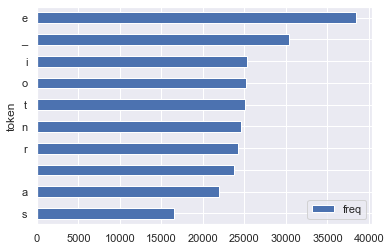

## Missing values computations 
For the rest of the columns we will handle the missing values one by one
IT IS VERY IMPORTANT BEFORE IMPUTING MISSING VALUES TO SPLIT THE DATA INTO TRAIN&TEST -> TO AVOID DATA LEAKAGE. __COMPUTATIONS SHOULD BE DONE ONLY ON THE TRAIN SET!__<br>
Use sklearn SimpleImputer or other in-built imputers -> and place it in a Pipeline. 
Before that - we need to do the text preprocessing of the Description

In [188]:
listings.isna().sum().sort_values(ascending = False)

review_scores_accuracy              823
review_scores_location              822
review_scores_value                 821
review_scores_checkin               820
review_scores_communication         818
review_scores_cleanliness           818
review_scores_rating                813
reviews_per_month                   756
last_review                         756
first_review                        756
host_response_time                  471
host_response_rate                  471
host_acceptance_rate                471
host_neighbourhood                  339
zipcode                              38
bathrooms                            14
market                               14
host_location                        11
bedrooms                             10
beds                                  9
property_type                         3
city                                  2
street                                0
access                                0
minimum_nights                        0


In [165]:
listings.head()

id                                           name  \
0  12147973                     Sunny Bungalow in the City   
1   3075044              Charming room in pet friendly apt   
2      6976               Mexican Folk Art Haven in Boston   
3   1436513  Spacious Sunny Bedroom Suite in Historic Home   
4   7651065                            Come Home to Boston   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0  Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pric   
1  Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston.  The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe s   
2  Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art. This is a well-maintained two-family house built in the 1940s. My apartment is on the second floor. This is a pet and smoke-free apartment.   PRICE: Price includes ALL utilities (heat, electricity, Wi-Fi, cable TV, air conditioner), parking in street, and use of back yard. NO SMOKING indoors or outside. Note that the bed is a size "Full" mattress, not a Queen or a K

<AxesSubplot:xlabel='price', ylabel='Count'>

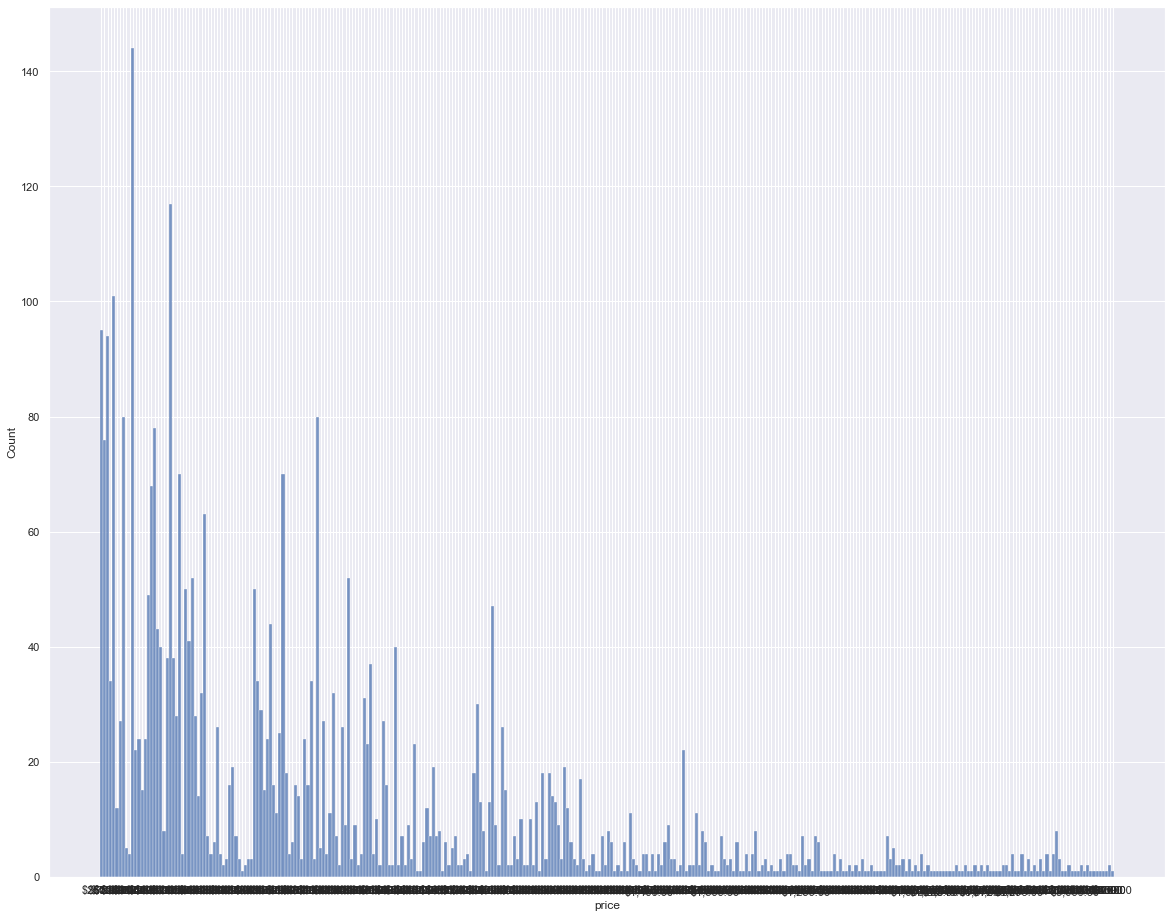

In [136]:
plt.figure(figsize=(20,16))
sns.histplot(listings['price'],bins=50)

In [121]:
listings['neighbourhood_cleansed'].value_counts()

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

In [124]:
listings['bathrooms'].value_counts()

1.0    2751
2.0     478
1.5     208
2.5      68
3.0      21
0.0      13
3.5      13
0.5       7
5.0       5
6.0       4
4.0       2
4.5       1
Name: bathrooms, dtype: int64

In [125]:
listings['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64